In [79]:
#import tweepy library
import tweepy
import json 
from collections import Counter
import os
import pickle
import twitter
import pandas as pd
import numpy as np
import ipywidgets as widget
from IPython.display import display, clear_output
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
import matplotlib.pyplot as plt
from tweepy import Stream
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import time
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import re

#declare and assign values to authorization variables
ConsumerKey = "e8yOMk1PYebFI6IqAmJPac9sY"
ConsumerSecret = "ghdd9BjIIkmIp9rHahIUrj6cLdMzMX35m8xRuDc19D7s4BOVHD"
AccessToken = "3770751192-URKr3kja687MI8HvZ6KcvwvfXEmup0YE9Cc7tyb"
AccessTokenSecret = "2TjrhbSiXOroOQVzWoMQ5ArB2ehIasUJ06hJmBBG9LzCX"
BearerToken = "AAAAAAAAAAAAAAAAAAAAADuIOwEAAAAAsOVffQU%2BTcjto0yCqpjKsjRSYq8%3DrSpogsdTnGTLgPWOxU5tmHvwf3X9n8gsEWLsHLxcy1QACmRlud"

fetchedTweetFileName = "realtimeStreamData.json"

#twitter authorization started
auth = tweepy.OAuthHandler(ConsumerKey, ConsumerSecret)
auth.set_access_token(AccessToken, AccessTokenSecret)

In [82]:
#define a function to return API authorization
def APIAuthorization():
    api = tweepy.API(auth)
    return api

def CleanTweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet).split())

def AnalyseSentiment(tweet):
    analysis= TextBlob(CleanTweet(tweet))
    if analysis.sentiment.polarity>0:
        return 1
    elif analysis.sentiment.polarity==0:
        return 0
    else:
        return -1

In [72]:
#define a variable that can directly be used to get data from twitter API
exractor = APIAuthorization()

In [73]:
#Q1: twitter realtime stream data fetching and injecting into local system file = realtimeStreamData.json, and showing top 10 results
class TwitterStreamer():
    def __init__(self):
        pass
    
    def StrimTweets(self, fetchedTweetFileName, hashTagList):
        listener = StdOutListener(fetchedTweetFileName)
        stream = Stream(auth, listener)
        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hashTagList)
        print(stream)
    

extractor= APIAuthorization()
numberOfTweets= 500
tweets1= extractor.user_timeline(screen_name= "nytimes", count= numberOfTweets)
print("Number of tweets Extracted: {}.\n".format(len(tweets1)))
print("Print recent tweets::\n")
for tweet in tweets1[:numberOfTweets]:
    print(tweet.text)
    print()

#save file to json
tweetData= pd.DataFrame(data= [tweet.text for tweet in  tweets1],columns= ['Tweets'])
tweetData.to_json(fetchedTweetFileName)

Number of tweets Extracted: 200.

Print recent tweets::

A former Los Angeles police officer who shot and killed a mentally disabled man inside a Costco store in 2019 was a… https://t.co/yyMRQKZLX8

Americans are flocking to national parks in record numbers. But if you want to bypass the crowds, one strategy is t… https://t.co/DnKtXULSUD

The British police did not respond to questions from the Times, citing concerns about prejudicing the inquest into… https://t.co/kPRTLEMe0X

The prosecution dropped the manslaughter charge against Daniela’s partner just before the trial was set to begin: c… https://t.co/LhVR32Keel

The New York Times obtained a confidential watchdog report into the police’s handling of Daniela’s case.

It reveal… https://t.co/KqbPi2UXmU

Britain's crisis of violence against women and girls has worsened during the pandemic — prosecution rates are shock… https://t.co/iDZTmc9w6b

Daniela Espirito Santo, 23, died after being assaulted by her boyfriend. She'd reported him 

In [61]:
#Q2: function to dump 50 trending topics (incuding topics) worldwide and print as per choosen from dropdown using pyspark          
btnSearch = widget.Button(
    description = "Search"
)


dropDownSelectNumber = widget.Dropdown(
    options=[('Ten', 10), ('Thirty', 30), ('Fifty', 50)],
    value=10,
    description='Number:',
)

dropDownSelectMinutes = widget.Dropdown(
    options=[('Ten Minutes', 10), ('Thirty Minutes', 30), ('Sixty Minutes', 60)],
    value=10,
    description='Last Minutes:',
)


WOE_ID = 1 #1=worldwide
def PrintTweets():
    clear_output()
    trends = exractor.trends_place(WOE_ID)
    #print(trends)
    trends = json.loads(json.dumps(trends, indent=1))
    trending = []
    for trend in trends[0]["trends"]:
        trending.append(trend["name"])
    trending
    data1= pd.DataFrame(trending,columns= ['Trends'])
    data1.to_csv('trendingTopics.csv')
    print()
    dataFrameJson = spark.read.csv('trendingTopics.csv', header=True)
    dataFrameJson.show(dropDownSelectNumber.value)
    
    
#define button click function
def TweetsByNumberAndMinutes(b):
    with outputDisplay:
        PrintTweets()
        
   

btnSearch.on_click(TweetsByNumberAndMinutes) 

outputDisplay = widget.Output()

items = [dropDownSelectNumber, dropDownSelectMinutes, btnSearch]
indx = widget.HBox([items[0], items[1], items[2]])
widget.VBox([indx, outputDisplay])




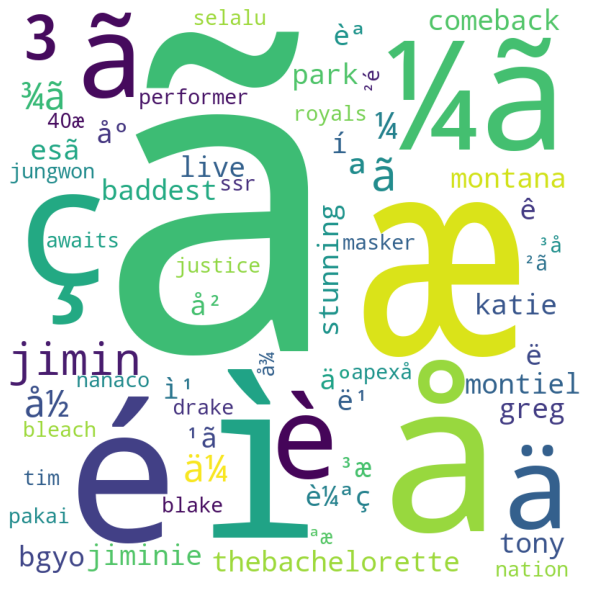

In [62]:
#Q4: showing data in Word Cloud model (Visualising data using Word Cloud model for both 2 and 3)
dataFrame = pd.read_csv(r"trendingTopics.csv", encoding ="latin-1") 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
 
for val in dataFrame.Trends: 
 
    val = str(val) 

    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
                      
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()



In [63]:
#Q3: top trending tweets
if not os.path.exists('secret_twitter_credentials.pk1'):
    Twitter = {}
    Twitter['Consumer Key'] = ConsumerKey
    Twitter['Consumer Secret'] = ConsumerSecret
    Twitter['Access Token'] = AccessToken
    Twitter['Access Token Secret'] = AccessTokenSecret
    with open('hashtags.csv','wb') as f:
        pickle.dump(Twitter,f)
else:
    Twitter = pickle.load(open('hashtags.csv','rb'))
    
auth = twitter.oauth.OAuth(Twitter['Access Token'],
                          Twitter['Access Token Secret'],
                          Twitter['Consumer Key'],
                          Twitter['Consumer Secret'])
twitterAPI = twitter.Twitter(auth=auth)
print(twitterAPI)

topic = input("Enter #topic_name: ")
number = 1000
searchResults = twitterAPI.search.tweets(q=topic, count=number)
statuses = searchResults['statuses'] 
len(statuses)   
allText =[]
filteredStatuses=[]
for s in statuses:
    if not s['text'] in allText:
        filteredStatuses.append(s)
        allText.append(s["text"])
statuses= filteredStatuses
len(statuses)
print(json.dumps(statuses[0], indent=1))
t = statuses[0]
print(t['retweet_count'])
print(t['retweeted'])
statusTexts = [status['text']
               for status in statuses]
screenNames = [user_mention['screen_name']
               for status in statuses
                   for user_mention in status['entities']['user_mentions']]
hashtags = [hashtag['text']
               for status in statuses
                   for hashtag in status['entities']['hashtags']]

#compute the collection of the words from all tweets
words = [w
        for t in statusTexts

         for w in t.split()]
print(json.dumps(statusTexts[:5],indent=1))
print(json.dumps(screenNames[:5],indent=1))
print(json.dumps(hashtags[:5],indent=1))
print(json.dumps(words[:5],indent=1))

for item in [words, screenNames, hashtags]:
    c=Counter(item)
    print(c.most_common()[:100]) 
    print() 

def prettyprint_counts(label,list_of_tuples):
    print("\n{:^20} | {:^6}".format(label,"Count"))
    print("*"*40)
    for k,v in list_of_tuples:
        print("{:20} | {:>6}".format(k,v))   
for label, data3 in (('word', words),
                   ('Screen Name', screenNames),
                   ('Hashtag', hashtags)):
    c = Counter(data3)
    prettyprint_counts(label,c.most_common()[:10])  

retweets = [
            (status['retweet_count'],
             status['retweeted_status']['user']['screen_name'],
             status['text'].replace("\n","\\"))
    
             for status in statuses
                if 'retweeted_status' in status
          ]  
row_template = "{:^7} | {:^15} | {:50}"
def prettyprint_tweets(list_of_tuples):
    print()
    print(row_template.format("Likes","Screen Name","Text"))
    print("*"*30)
    for count, screenNames, text in list_of_tuples:
        print(row_template.format(count, screenNames,text[:50]))

        if len(text)>50:
            print(row_template.format("","",text[50:100]))
            if len(text)>100:
                print(row_template.format("","",text[100:])) 

prettyprint_tweets(sorted(retweets, reverse=True)[:100])
data8= pd.DataFrame(screenNames, columns= ['screenNames'])
data8.to_csv('ScreenName.csv')

Enter #topic_name: test
{
 "created_at": "Tue Aug 10 10:22:54 +0000 2021",
 "id": 1425039949271900163,
 "id_str": "1425039949271900163",
 "text": "RT @AOC_Gaming: It's time to put your skills to the test. Using your creativity &amp;  every ounce of legendary,  show us the spirit of #WhatMa\u2026",
 "truncated": false,
 "entities": {
  "hashtags": [],
  "symbols": [],
  "user_mentions": [
   {
    "screen_name": "AOC_Gaming",
    "name": "AGON by AOC",
    "id": 2461989242,
    "id_str": "2461989242",
    "indices": [
     3,
     14
    ]
   }
  ],
  "urls": []
 },
 "metadata": {
  "iso_language_code": "en",
  "result_type": "recent"
 },
 "source": "<a href=\"http://twitter.com/download/android\" rel=\"nofollow\">Twitter for Android</a>",
 "in_reply_to_status_id": null,
 "in_reply_to_status_id_str": null,
 "in_reply_to_user_id": null,
 "in_reply_to_user_id_str": null,
 "in_reply_to_screen_name": null,
 "user": {
  "id": 1006262051868639233,
  "id_str": "1006262051868639233",
  "name": 

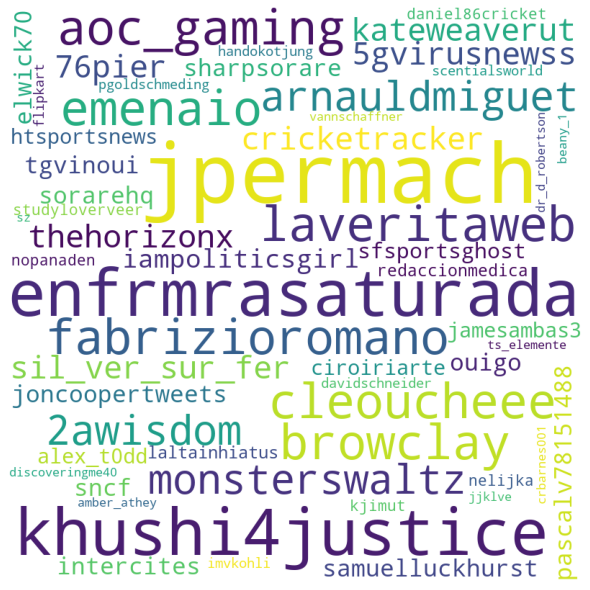

In [64]:
#Q4: showing data in Word Cloud model (Visualising data using Word Cloud model for both 2 and 3)
df6 = pd.read_csv(r"ScreenName.csv", encoding ="latin-1") 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df6.screenNames: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'retweeted_status',
       'is_quote_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'lang', 'extended_entities', 'possibly_sensitive'],
      dtype='object')
0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
30      0
31     25
32      0
33     13
34      0
35     20
36      0
37      0
38      0
39      0
40      0
41      0
42    125
43      0
44      0
45     29
46     31
47      0
48      0
49     49
50    

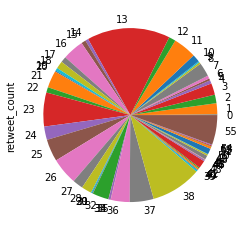

Number of tweets: 56
Total number of likes: 504
Total number of retweets: 8989


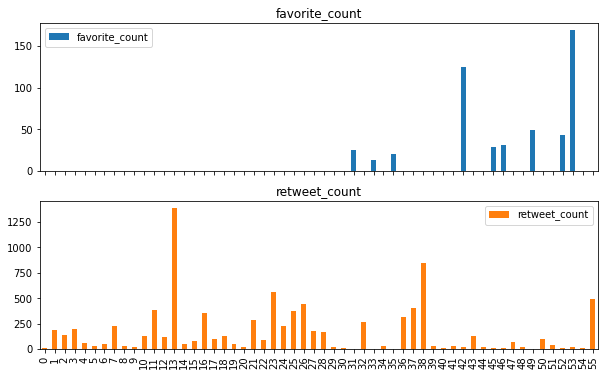

Data for CNN
Number of tweets: 56
Number of likes: 504
Number of likes per tweet: 9.0
Number of retweets: 8989
Number of retweets per tweet: 160.51785714285714


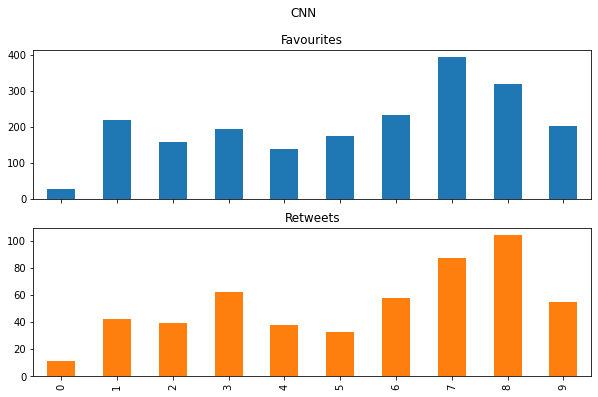

Data for BBCWorld
Number of tweets: 56
Number of likes: 504
Number of likes per tweet: 9.0
Number of retweets: 8989
Number of retweets per tweet: 160.51785714285714


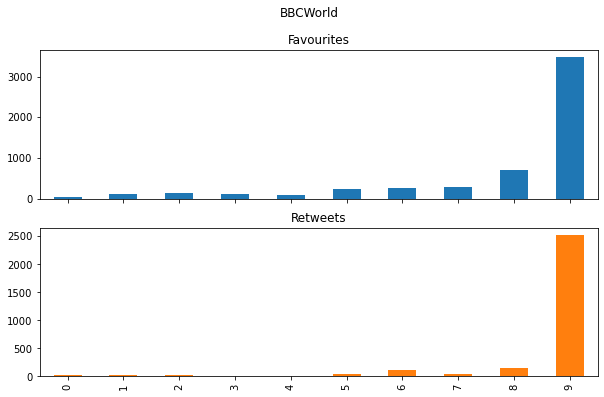

In [65]:
#Q5: Demonstrating any (one or more) additional/arbitrary insights on the data using ML or none-ML data analytics approaches (5% per insight)
CONSUMER_KEY= ConsumerKey
CONSUMER_SECRET= ConsumerSecret
ACCESS_SECRET= AccessTokenSecret
ACCESS_TOKEN= AccessToken

auth = twitter.oauth.OAuth(ACCESS_TOKEN, ACCESS_SECRET, CONSUMER_KEY, CONSUMER_SECRET)

twitterApi = twitter.Twitter(auth=auth)
tweets = twitterApi.search.tweets(q="BBC", count=100)
tweets = twitterApi.search.tweets(q="from:BBC", count=100)
tweetData = pd.DataFrame(tweets['statuses'])

print(tweetData.columns)
print(tweetData['favorite_count'])

tweetData['retweet_count'].plot.pie()
plt.show()

# Get the data
tweetCount = len(tweetData)
favoriteCount = tweetData['favorite_count'].sum()
retweetCount = tweetData['retweet_count'].sum()

# Print it out
print('Number of tweets: ' + str(tweetCount))
print('Total number of likes: ' + str(favoriteCount))
print('Total number of retweets: ' + str(retweetCount))

# Draw a nice plot of the likes and retweets
tweetData.plot.bar(subplots=True, figsize=(10,6),y=['favorite_count','retweet_count'])
plt.show()
names = ['CNN','BBCWorld']
for name in names:
  tweets = pd.DataFrame(twitterApi.search.tweets(q="from:"+name, count=10)['statuses'])
  tweet_count = len(tweets)
  favorite_count = tweets['favorite_count'].sum()
  retweet_count = tweets['retweet_count'].sum()

  print("Data for "+name)
  print('Number of tweets: ' + str(tweetCount))
  print('Number of likes: ' + str(favoriteCount))
  print('Number of likes per tweet: '+str(favoriteCount/tweetCount))
  print('Number of retweets: ' + str(retweetCount))
  print('Number of retweets per tweet: '+str(retweetCount/tweetCount))

  tweets.plot.bar(subplots=True, figsize=(10,6),y=
    ['favorite_count','retweet_count'],
    legend=False,label=['Favourites','Retweets'],title=name)

  plt.show()

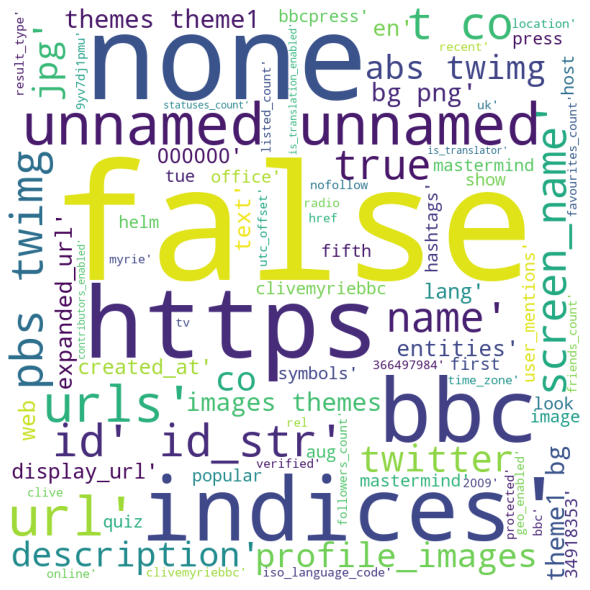

In [66]:
dataFrame4 = pd.DataFrame(data = tweetData)
dataFrame4.to_csv('file4.csv', index=False, header=None)
dataFrame4 = pd.read_csv(r"file4.csv", encoding ="latin-1") 

comment_words = '' 
stopwords = set(STOPWORDS) 

# iterate through the csv file 
for val in dataFrame4: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [67]:
print(tweetData)

                        created_at                   id               id_str  \
0   Tue Aug 10 09:49:23 +0000 2021  1425031514186829828  1425031514186829828   
1   Tue Aug 10 08:57:51 +0000 2021  1425018545235189761  1425018545235189761   
2   Tue Aug 10 08:57:44 +0000 2021  1425018516890177544  1425018516890177544   
3   Mon Aug 09 08:11:59 +0000 2021  1424644615001546756  1424644615001546756   
4   Sun Aug 08 15:57:45 +0000 2021  1424399442388606978  1424399442388606978   
5   Sun Aug 08 15:57:39 +0000 2021  1424399414475505665  1424399414475505665   
6   Sun Aug 08 11:14:40 +0000 2021  1424328202974081028  1424328202974081028   
7   Sun Aug 08 09:55:25 +0000 2021  1424308255161999367  1424308255161999367   
8   Sun Aug 08 08:56:19 +0000 2021  1424293384676679683  1424293384676679683   
9   Sun Aug 08 08:55:53 +0000 2021  1424293275356237830  1424293275356237830   
10  Sun Aug 08 08:53:38 +0000 2021  1424292709355991041  1424292709355991041   
11  Sun Aug 08 07:40:49 +0000 2021  1424

In [74]:
tweetData['length']= np.array([len(tweet.text) for tweet in tweets1])
tweetData['ID']= np.array([tweet.id for tweet in tweets1])
tweetData['Date']= np.array([tweet.created_at for tweet in tweets1])
tweetData['Sources']= np.array([tweet.source for tweet in tweets1])
tweetData['Likes']= np.array([tweet.favorite_count for tweet in tweets1])
tweetData['Rts']= np.array([tweet.retweet_count for tweet in tweets1])

In [75]:
mean= np.mean(tweetData['length'])
fmax= np.max(tweetData['Likes'])
rts= np.max(tweetData['Rts'])
print(mean)
print(fmax) # Most Liked
print(rts) # retweeted

137.555
16891
9475


In [76]:
favTweet= tweetData[tweetData.Likes== fmax]
print(favTweet['Tweets'])
print(fmax)

127    Global warming will get progressively worse an...
Name: Tweets, dtype: object
16891


In [77]:
sources= []
for i in tweetData['Sources']:
    if i not in sources:
        sources.append(i)

print("Print the List of All the sources:")
for i in sources:
    print('* {}'.format(i))

Print the List of All the sources:
* SocialFlow
* Twitter Web App


In [83]:
tweetData['Sentiment']= np.array([AnalyseSentiment(tweet) for tweet in tweetData['Tweets']])
display(tweetData.head(10))

,Tweets,length,ID,Date,Sources,Likes,Rts,Sentiment
0,A former Los Angeles police officer who shot a...,140,1425034241193267226,2021-08-10 10:00:13,SocialFlow,183,52,-1
1,Americans are flocking to national parks in re...,140,1425026670176751624,2021-08-10 09:30:08,SocialFlow,141,29,0
2,The British police did not respond to question...,139,1425020487973974017,2021-08-10 09:05:34,Twitter Web App,48,8,0
3,The prosecution dropped the manslaughter charg...,140,1425020486677942290,2021-08-10 09:05:34,Twitter Web App,52,7,0
4,The New York Times obtained a confidential wat...,140,1425020484547235863,2021-08-10 09:05:33,Twitter Web App,18,5,1
5,Britain's crisis of violence against women and...,140,1425020479975444488,2021-08-10 09:05:32,Twitter Web App,33,8,0
6,"Daniela Espirito Santo, 23, died after being a...",140,1425018864585388032,2021-08-10 08:59:07,SocialFlow,376,109,0
7,A Chinese court upheld the death sentence of R...,140,1425015332197085184,2021-08-10 08:45:05,SocialFlow,169,45,0
8,RT @jane__bradley: Daniela Espirito Santo died...,140,1425012313896149012,2021-08-10 08:33:05,SocialFlow,0,144,0
9,"The world does not lack scents, Ernesto Collad...",140,1425011551472283657,2021-08-10 08:30:03,SocialFlow,122,28,1


In [84]:
ps=0
ns=0
nn=0
for sa in tweetData['Sentiment']:
    if sa>0.0:
        ps+=1
    elif sa<0.0:
        ns+=1
    else:
        nn+=1
        
print("Percentage of positive sentiment : {}%".format(ps*100/len(tweetData['Tweets'])))
print("Percentage of Negative Sentiment : {}%".format(ns*100/len(tweetData['Tweets'])))
print("Percentage of Neutral sentiment : {}%".format(nn*100/len(tweetData['Tweets'])))

Percentage of positive sentiment : 46.0%
Percentage of Negative Sentiment : 17.0%
Percentage of Neutral sentiment : 37.0%
